In [1]:
import os
import sys
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Iterable, Tuple, List
import tensorflow as tf
if not tf.config.list_physical_devices('GPU'):
    print('Warning: without a GPU the training will take a long time...')


In [2]:
# Constants
IMAGE_SIZE = (256, 256, 3)
NUM_CLASSES = 125
# SKETCH_ROOT = '/Users/taehun.kim/mids/rendered_256x256/256x256/sketch'
SKETCH_ROOT = r'D:\Documents\MIDS\W281\2023-mids-w81-final-project-dataset\256x256\sketch'
assert os.path.isdir(SKETCH_ROOT)

## Load images as tensorflow dataset

In [12]:
def get_image_dataset(ratios: List[float], augmentations: List[str] = None, color_mode: str = 'rgb',
                    seed: int = 1, batch_size: int = 32) -> List[tf.data.Dataset]:
    '''
    Get tensorflow dataset using generator to avoid RAM limitations
    Splits into train, val, test from all provided augmentations 
    '''

    # No augmentation by default
    augmentations = augmentations or ['tx_000000000000']

    assert sum(ratios) == 1 and len(ratios) == 3, 'Sum of 3 ratios must add to 1'

    datasets: List[Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]] = []
    for aug in augmentations:
        print(f'Reading images from augmentation {aug}...')
        train_ds = tf.keras.utils.image_dataset_from_directory(
            directory = os.path.join(SKETCH_ROOT, aug),
            image_size = IMAGE_SIZE[:2],
            label_mode='categorical',
            seed = seed,
            color_mode = color_mode,
            validation_split = (1 - ratios[0]),
            subset = 'training',
            batch_size=batch_size
        )

        val_ds = tf.keras.utils.image_dataset_from_directory(
            directory = os.path.join(SKETCH_ROOT, aug),
            image_size = IMAGE_SIZE[:2],
            label_mode='categorical',
            seed = seed,
            color_mode = 'rgb',
            validation_split = (1 - ratios[0]),
            subset = 'validation',
            batch_size=batch_size
        )

        val_batch_count = int(tf.data.experimental.cardinality(val_ds))
        test_ds = val_ds.take(int(val_batch_count * ratios[1]))
        val_ds = val_ds.skip(int(val_batch_count * ratios[1]))

        datasets.append([train_ds, val_ds, test_ds])
    
    combined = datasets.pop()
    for train, val, test in datasets:
        combined[0] = combined[0].concatenate(train)
        combined[1] = combined[1].concatenate(val)
        combined[2] = combined[2].concatenate(test)

    return [c.shuffle(batch_size) for c in combined]

In [4]:
train_ds, val_ds, test_ds = get_image_dataset([0.8, 0.1, 0.1], augmentations=['tx_000100000000'])

Reading images from augmentation tx_000100000000...
Found 75481 files belonging to 125 classes.
Using 60385 files for training.
Found 75481 files belonging to 125 classes.
Using 15096 files for validation.


In [ ]:
HOG_INPUT_SIZE = (2048,)

def get_hog_features(ratios: List[float], augmentations: List[str] = None,
                     seed: int = 1, batch_size: int = 32) -> List[tf.data.Dataset]:
    '''
    Get tensorflow dataset using generator to avoid RAM limitations
    Splits into train, val, test from all provided augmentations 
    '''
    # TODO: implement this
    pass
    # def reshape_hog_to_vector(input):
    #     input.reshape()
    

    # train, val, test = get_image_dataset(ratios, augmentations, seed, batch_size, color_mode='grayscale')
    # train.map(lambda image: tf.image.resize_image_with_crop_or_pad(image, 224, 224))

In [8]:
import math

def _build_resnet_layers():
    pretrained_resnet = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=IMAGE_SIZE,
        pooling='avg',
        classes=125,
    )
    pretrained_resnet.trainable = False

    tf.keras.backend.clear_session()
    layer = tf.keras.layers.Dense(1024, activation='relu')(pretrained_resnet.output)
    layer = tf.keras.layers.Dense(512, activation='relu')(layer)
    return pretrained_resnet.input, layer

def build_naive_cnn():
    cnn_input, cnn_output = _build_resnet_layers()
    
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(cnn_output)
    return tf.keras.Model(cnn_input, outputs)

def build_cnn_with_hog():
    cnn_input, cnn_output = _build_resnet_layers()

    hog_shape = (math.prod(IMAGE_SIZE),)
    hog_input = tf.keras.layers.Input(shape=hog_shape, name='hog_input')

    combined_output = tf.keras.layers.Concatenate()([cnn_output, hog_input])
    return tf.keras.Model(inputs=[cnn_input, hog_input], outputs=combined_output)


In [3]:
model = build_naive_cnn()

NameError: name 'tf' is not defined

In [6]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
# Reduce training size on non-powerful machines
reduce_training_size = False
actual_train_ds = train_ds.take(tf.data.experimental.cardinality(train_ds) // 100) if reduce_training_size else train_ds

epochs = 10
history = model.fit(
  actual_train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
1888/1888 [==============================] - 351s 182ms/step - loss: 2.1408 - accuracy: 0.4526 - val_loss: 1.5499 - val_accuracy: 0.5767
Epoch 2/10
1888/1888 [==============================] - 309s 164ms/step - loss: 1.4070 - accuracy: 0.6142 - val_loss: 1.3754 - val_accuracy: 0.6278
Epoch 3/10
1888/1888 [==============================] - 234s 124ms/step - loss: 1.1881 - accuracy: 0.6661 - val_loss: 1.2595 - val_accuracy: 0.6558
Epoch 4/10
1888/1888 [==============================] - 233s 123ms/step - loss: 1.0509 - accuracy: 0.7009 - val_loss: 1.2645 - val_accuracy: 0.6647
Epoch 5/10
1888/1888 [==============================] - 233s 123ms/step - loss: 0.9449 - accuracy: 0.7270 - val_loss: 1.2199 - val_accuracy: 0.6801
Epoch 6/10
1888/1888 [==============================] - 233s 123ms/step - loss: 0.8788 - accuracy: 0.7435 - val_loss: 1.3022 - val_accuracy: 0.6738
Epoch 7/10
1888/1888 [==============================] - 233s 123ms/step - loss: 0.7922 - accuracy: 0.7674 - val_

In [7]:
def plot_results(history, show_plot: bool = True):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    # Retrieve the training metrics (after each train epoch) and the final test accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    ax1.set_title('Accuracy')
    ax1.plot(train_accuracy, label='train_accuracy')
    ax1.plot(val_accuracy, label='validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.set_title('Loss')
    ax2.plot(train_loss, label='train loss')
    ax2.plot(val_loss, label='validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()

    if show_plot:
        plt.show()

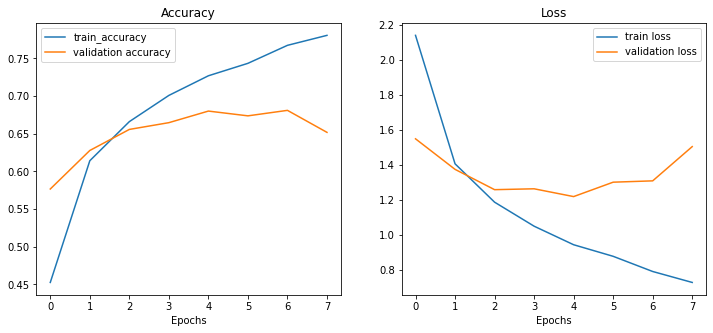

In [9]:
plot_results(history)

## Automate saving experiment results

In [8]:
# Run and save experiment

from typing import Any

RESULTS_ROOT = r'D:\Documents\MIDS\W281\2023-mids-w281-final-project\results'

def run_and_save_experiment(name: str, 
                            model: Any,
                            train_ds: tf.data.Dataset,
                            val_ds: tf.data.Dataset,
                            reduce_training_size: bool = False):
    
    experiment_dir = os.path.join(RESULTS_ROOT, name)
    os.makedirs(experiment_dir, exist_ok=True)

    actual_train_ds = train_ds.take(tf.data.experimental.cardinality(train_ds) // 100) if reduce_training_size else train_ds

    epochs = 10
    history = model.fit(
        actual_train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )

    model.save_weights(os.path.join(experiment_dir, f'{name}_model_weights.h5'))

    plot_results(history, show_plot=False)
    plt.savefig(os.path.join(experiment_dir, f'{name}_history.png'))

    with open(os.path.join(experiment_dir, f'{name}_model_summary.txt'), 'w') as f:
        f.write(f'\nTraining accuracy: {max(history.history["accuracy"])}')
        f.write(f'\nValidation accuracy: {max(history.history["val_accuracy"])}')
    

Epoch 1/10
11328/11328 [==============================] - 1524s 134ms/step - loss: 1.5321 - accuracy: 0.5845 - val_loss: 1.4602 - val_accuracy: 0.6140
Epoch 2/10
11328/11328 [==============================] - 1449s 128ms/step - loss: 1.0581 - accuracy: 0.6991 - val_loss: 1.3968 - val_accuracy: 0.6456
Epoch 3/10
11328/11328 [==============================] - 1449s 128ms/step - loss: 0.9177 - accuracy: 0.7356 - val_loss: 1.4511 - val_accuracy: 0.6563
Epoch 4/10
11328/11328 [==============================] - 1452s 128ms/step - loss: 0.8365 - accuracy: 0.7583 - val_loss: 1.4804 - val_accuracy: 0.6556
Epoch 5/10
11328/11328 [==============================] - 1450s 128ms/step - loss: 0.7807 - accuracy: 0.7737 - val_loss: 1.5199 - val_accuracy: 0.6602


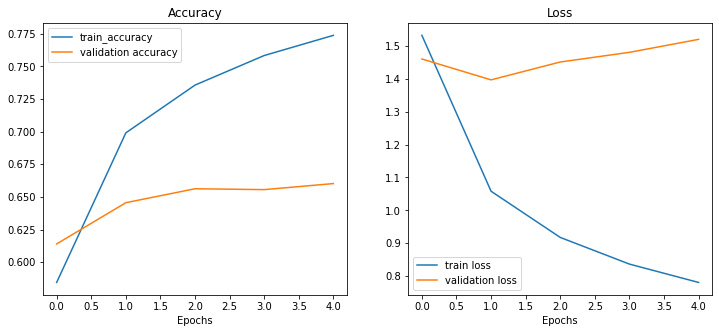

In [9]:
run_and_save_experiment('naive_res50_tx_all', model, train_ds, val_ds)